In [1]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import torch
from torchvision.models import alexnet, vgg19, inception_v3, resnet50
import timm
from torch.utils.data import Dataset, DataLoader
from thop import profile
from tool import trainer, imageDataset
import matplotlib.pyplot as plt
torch.__version__

'2.0.0+cu117'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 1
EPOCHS = 10
LR = 1e-4
TEST_SIZE = 0.15

### 讀取資料

In [3]:
dir_path = './data/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)

print(f'資料共{len(data_path)}筆')

資料共239筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共203筆
驗證資料共36筆
CPU times: user 870 µs, sys: 0 ns, total: 870 µs
Wall time: 772 µs


### Data Preocess and set DataLoader

In [7]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

# set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=36, shuffle = False)

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 5.37 s, sys: 359 ms, total: 5.73 s
Wall time: 5.74 s


# 各模型比較

### alexnet
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 62.07% | Train_loss: 191.6425
--------------------Epoch 2--------------------
Train_accuracy: 65.02% | Train_loss: 178.7754
--------------------Epoch 3--------------------
Train_accuracy: 65.02% | Train_loss: 176.6537
--------------------Epoch 4--------------------
Train_accuracy: 66.50% | Train_loss: 164.7100
--------------------Epoch 5--------------------
Train_accuracy: 66.50% | Train_loss: 154.6744
--------------------Epoch 6--------------------
Train_accuracy: 67.98% | Train_loss: 143.7025
--------------------Epoch 7--------------------
Train_accuracy: 69.46% | Train_loss: 143.7906
--------------------Epoch 8--------------------
Train_accuracy: 72.91% | Train_loss: 128.5949
--------------------Epoch 9--------------------
Train_accuracy: 75.37% | Train_loss: 116.3537
--------------------Epoch 10--------------------
Train_accuracy: 80.30% | Train_loss: 104.5334


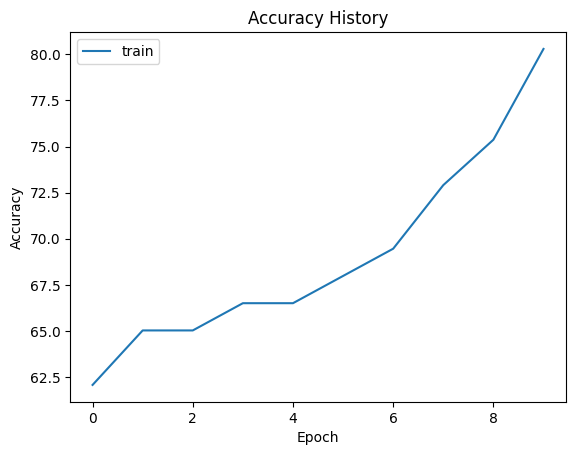

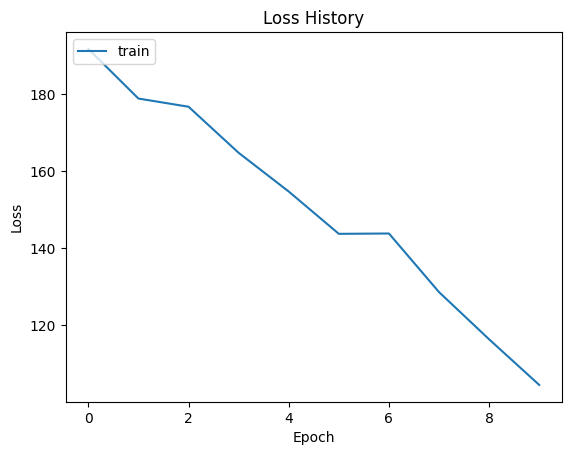

Accuracy on the test images: 58.33%
Inference time: 16.2609 milliseconds


In [8]:
# pre-trained model(https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet)
model = alexnet(pretrained=True).to(device)
# Modify the last layer(num_classes: 1000 => 3), Replace the last layer with a new fully connected layer with 3 output units(ChatGPT)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
alexnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-5)
# train process
alexnet_trainer.train()
alexnet_trainer.predict()

In [ ]:
# Show the feature map
layer1 = model.features[0]
input,output = next(iter(train_loader))
print(input.shape)
input = input.to(device)
output = output.to(device)
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_image[i], cmap='gray')
    plt.axis('off') 


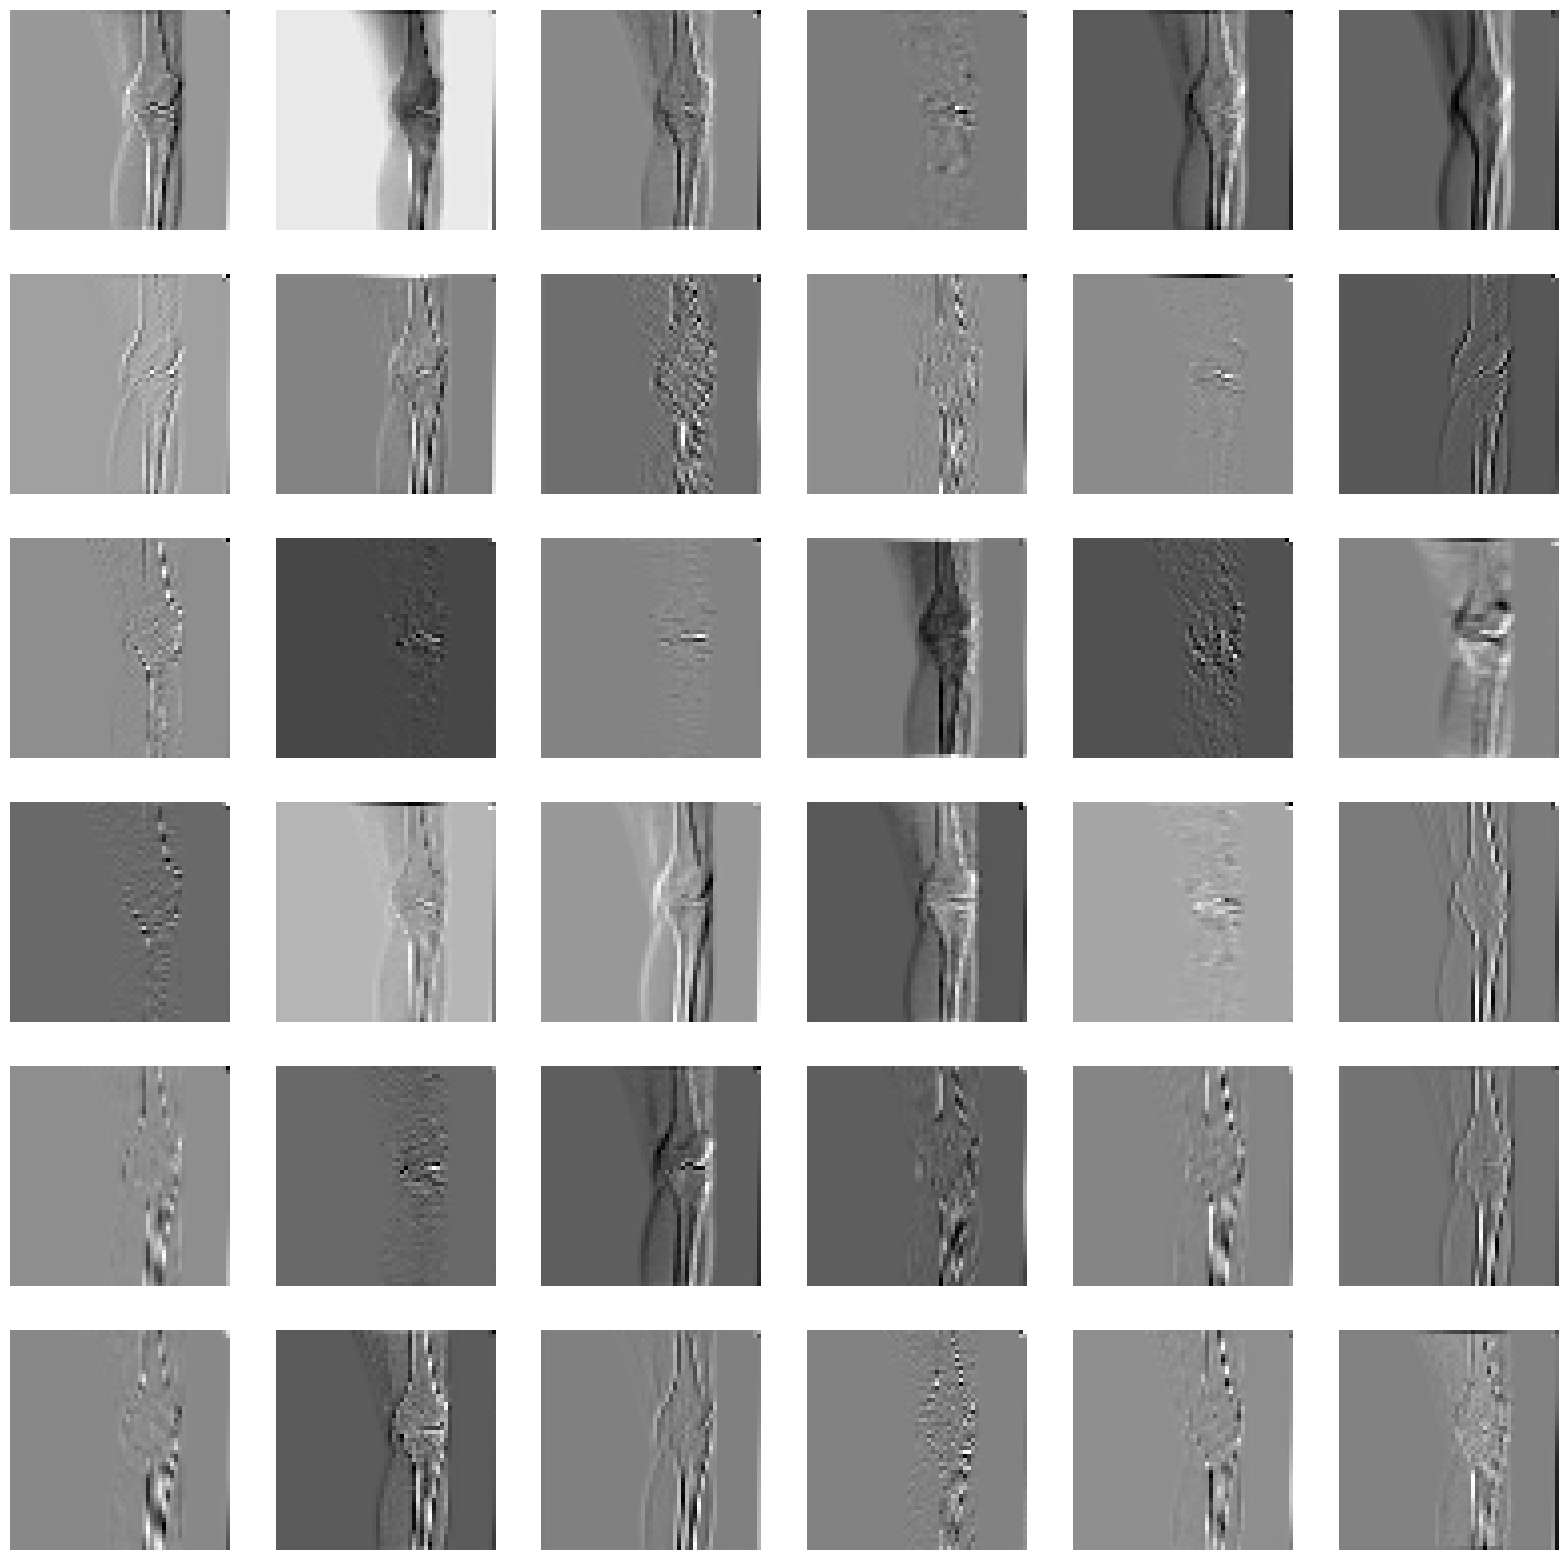

In [9]:
# show the feature map
# alexnet_trainer.show_feature_map()

### VGG19
- https://pytorch.org/vision/0.11/models.html?highlight=vgg19#torchvision.models.vgg19

--------------------Epoch 1--------------------
Train_accuracy: 61.58% | Train_loss: 12.6233
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 11.8579
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 11.7626
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 11.4315
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 11.6228
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 11.4930
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 11.1611
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 10.9461
--------------------Epoch 9--------------------
Train_accuracy: 65.52% | Train_loss: 10.4962
--------------------Epoch 10--------------------
Train_accuracy: 68.47% | Train_loss: 10.0482


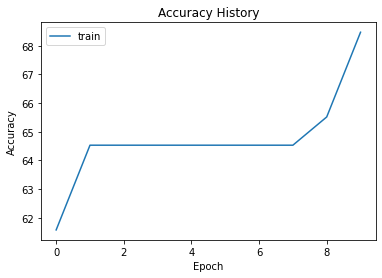

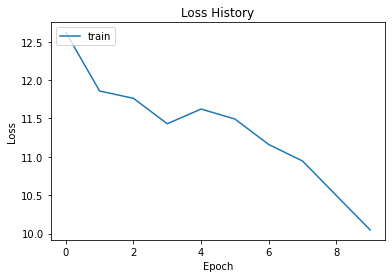

Accuracy on the test images: 66.67%
Inference time: 46.3923 milliseconds


In [11]:
model = vgg19(pretrained=True).to(device)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
vgg19_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vgg19_trainer.train()
vgg19_trainer.predict()

### resnet50
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 64.53% | Train_loss: 193.8390
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 171.2081
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 160.4815
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 152.8775
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 146.7381
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 141.4485
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 136.5127
--------------------Epoch 8--------------------
Train_accuracy: 65.02% | Train_loss: 131.7215
--------------------Epoch 9--------------------
Train_accuracy: 65.52% | Train_loss: 127.2000
--------------------Epoch 10--------------------
Train_accuracy: 65.52% | Train_loss: 122.6624


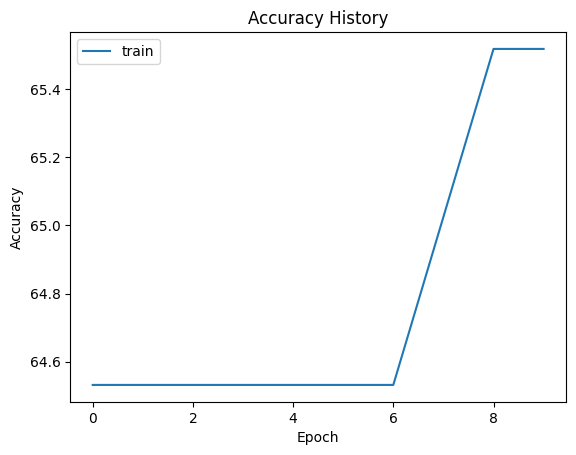

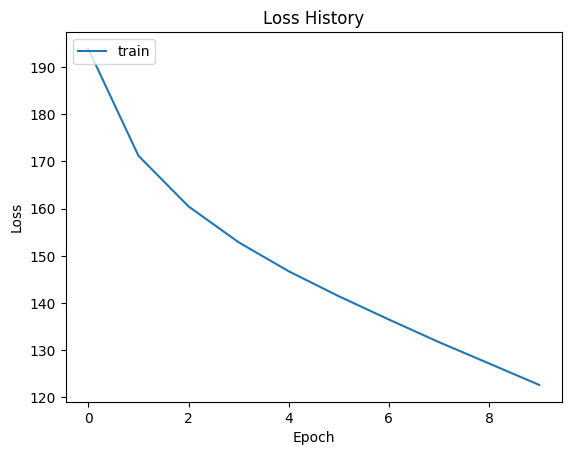

Accuracy on the test images: 63.89%
Inference time: 107.1582 milliseconds


In [10]:
model = resnet50(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3).to(device)

resnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
resnet_trainer.train()
resnet_trainer.predict()

In [29]:
layer1 = model.conv1
print(input.shape)
layer1.forward(input)

torch.Size([1, 3, 224, 224])


tensor([[[[ 2.7659e-01,  3.3152e-01,  1.8159e-01,  ...,  1.8014e-01,
            3.2316e-01,  3.0177e-01],
          [-4.0782e-01, -1.7846e-01,  1.1475e-01,  ..., -3.0756e-01,
           -3.4666e-01,  4.3220e-02],
          [-4.6976e-02, -1.5849e-01, -1.7302e-01,  ..., -7.9283e-02,
           -2.3014e-01, -2.9927e-01],
          ...,
          [-5.2091e-02,  8.6130e-02, -9.0351e-02,  ..., -8.9283e-02,
           -9.0420e-02, -5.5299e-02],
          [-2.7380e-01, -1.7839e-01, -1.3328e-04,  ..., -1.8500e-02,
           -2.2606e-02, -8.9102e-02],
          [ 2.0980e-01,  8.0706e-02,  6.7204e-02,  ...,  7.0123e-02,
            7.6247e-02,  5.4007e-02]],

         [[ 1.2778e-02,  1.0932e-02,  1.2719e-02,  ...,  8.9079e-03,
            1.4614e-02,  1.4654e-02],
          [-4.6327e-03, -6.8437e-03,  1.1192e-02,  ..., -5.1607e-03,
           -4.9215e-03,  1.0055e-02],
          [ 6.3840e-03,  3.0178e-03,  2.0147e-02,  ...,  2.3251e-03,
            6.0644e-03,  1.8325e-02],
          ...,
     

torch.Size([1, 3, 224, 224])
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([1, 64, 56, 56])
(64, 56, 56)


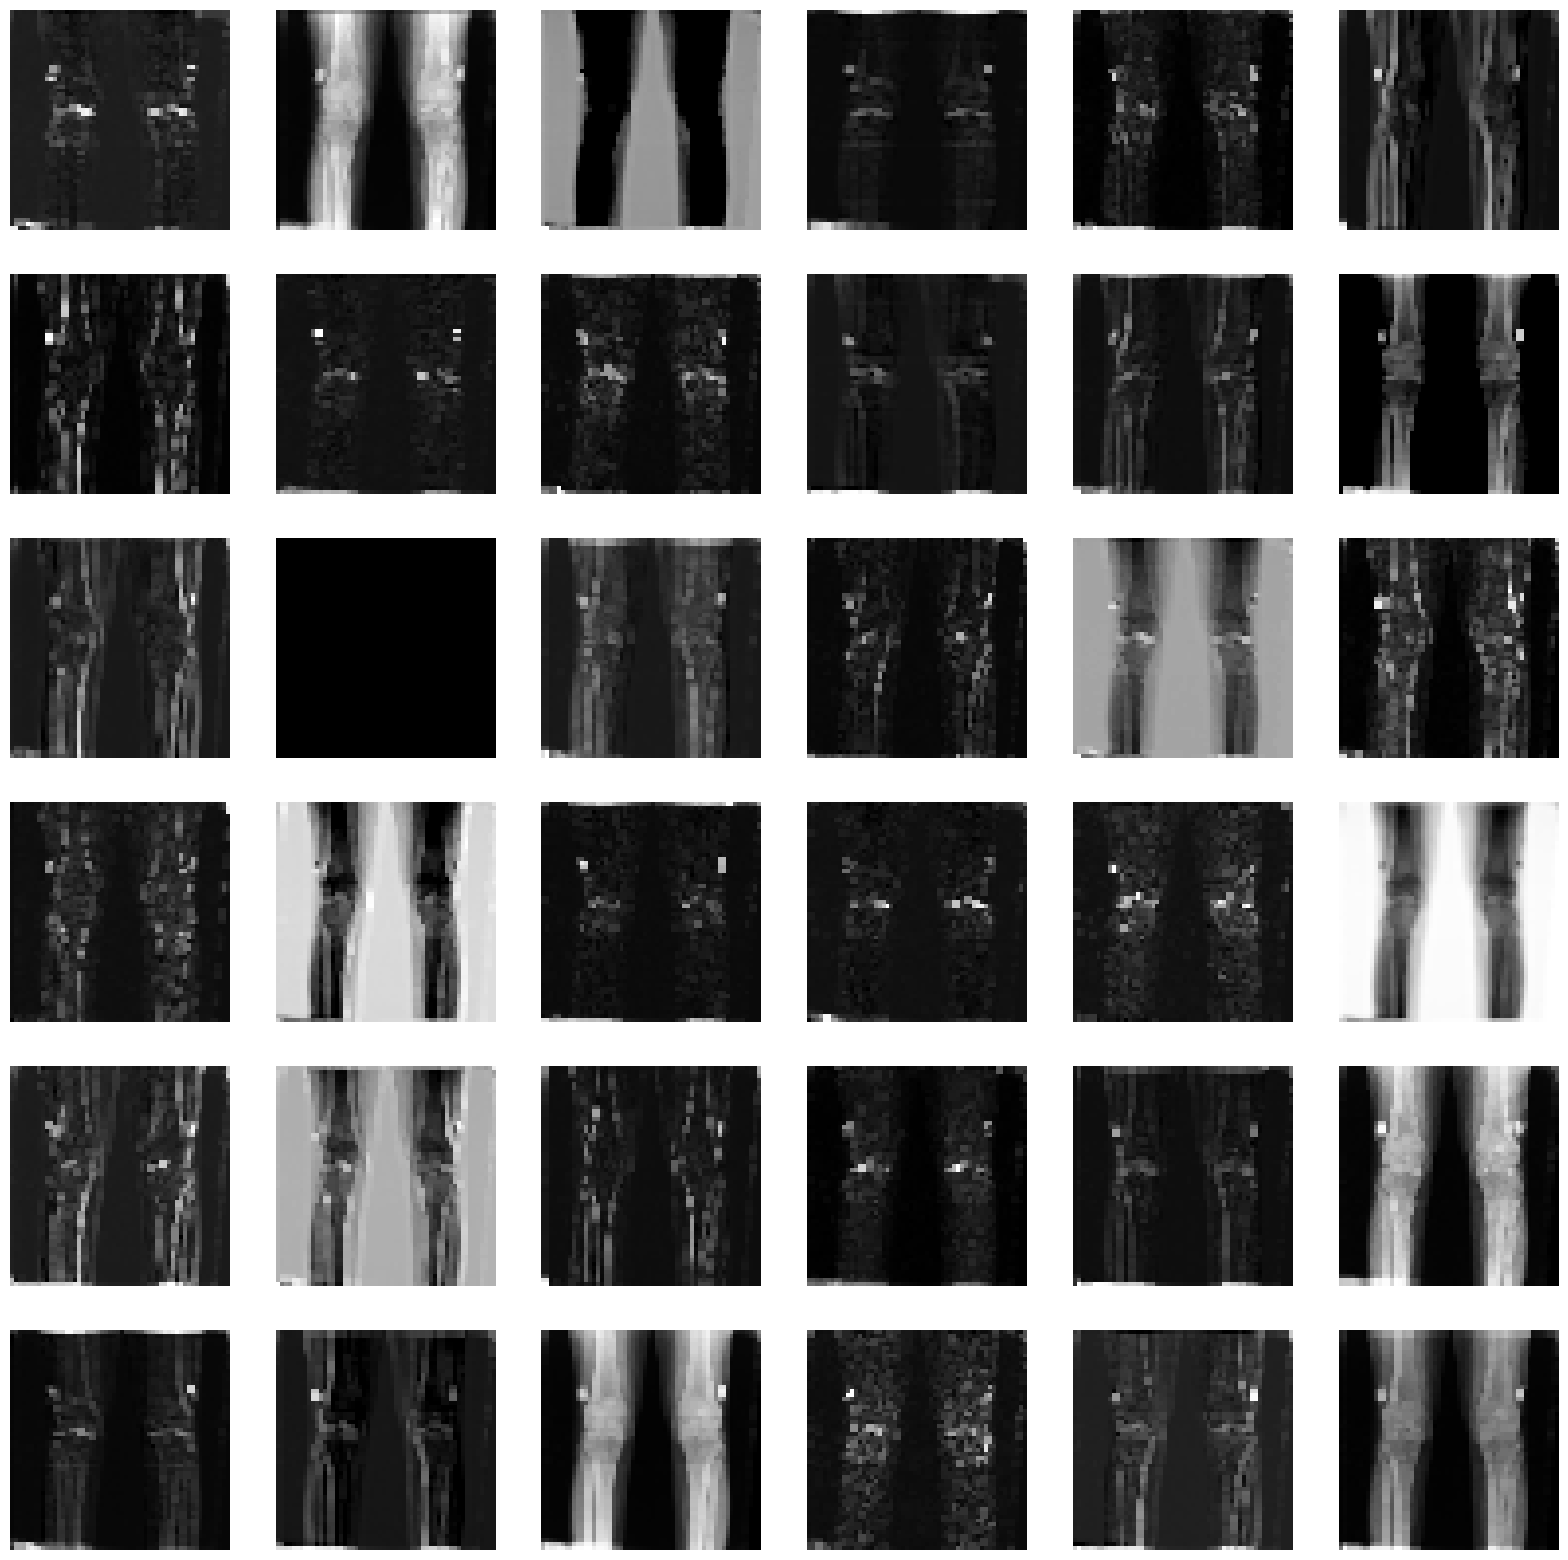

In [31]:
# show the feature map
# resnet_trainer.show_feature_map()

# layer1 = model.conv1
input,output = next(iter(train_loader))
print(input.shape)
input = input.to(device)
output = output.to(device)
feature_map = model.conv1.forward(input)
feature_map = model.bn1.forward(feature_map)
feature_map = model.relu.forward(feature_map)
feature_map = model.maxpool.forward(feature_map)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_image[i], cmap='gray')
    plt.axis('off') 

### inception_v4
- https://huggingface.co/docs/timm/models/inception-v4

--------------------Epoch 1--------------------
Train_accuracy: 33.00% | Train_loss: 223.9042
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 195.7214
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 179.3721
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 170.7546
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 166.9352
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 160.3542
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 154.7593
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 149.1169
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 143.7490
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 140.4121


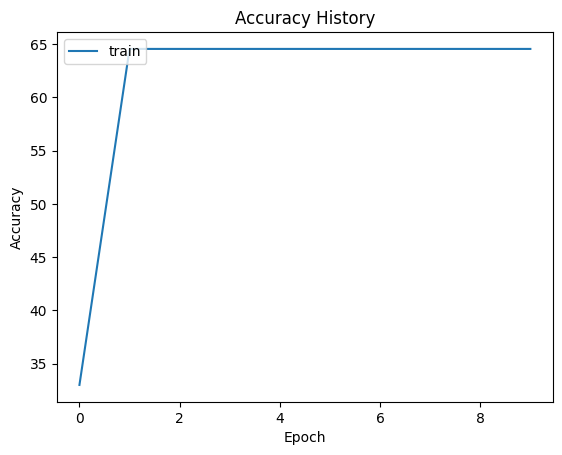

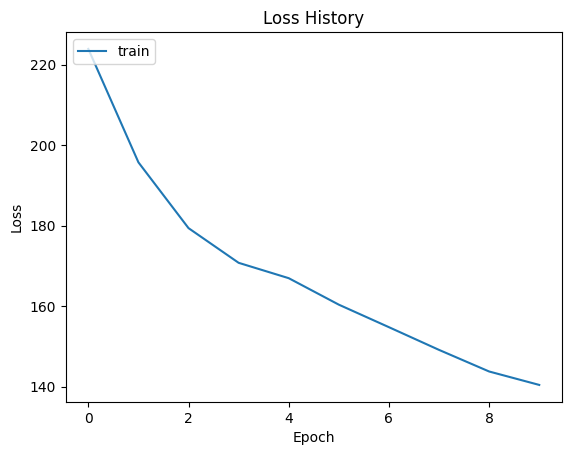

Accuracy on the test images: 63.89%
Inference time: 175.9255 milliseconds


In [32]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
inception_v4_trainer.train()
inception_v4_trainer.predict()

torch.Size([1, 3, 224, 224])
ConvNormAct(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
)
torch.Size([1, 32, 111, 111])
(32, 111, 111)


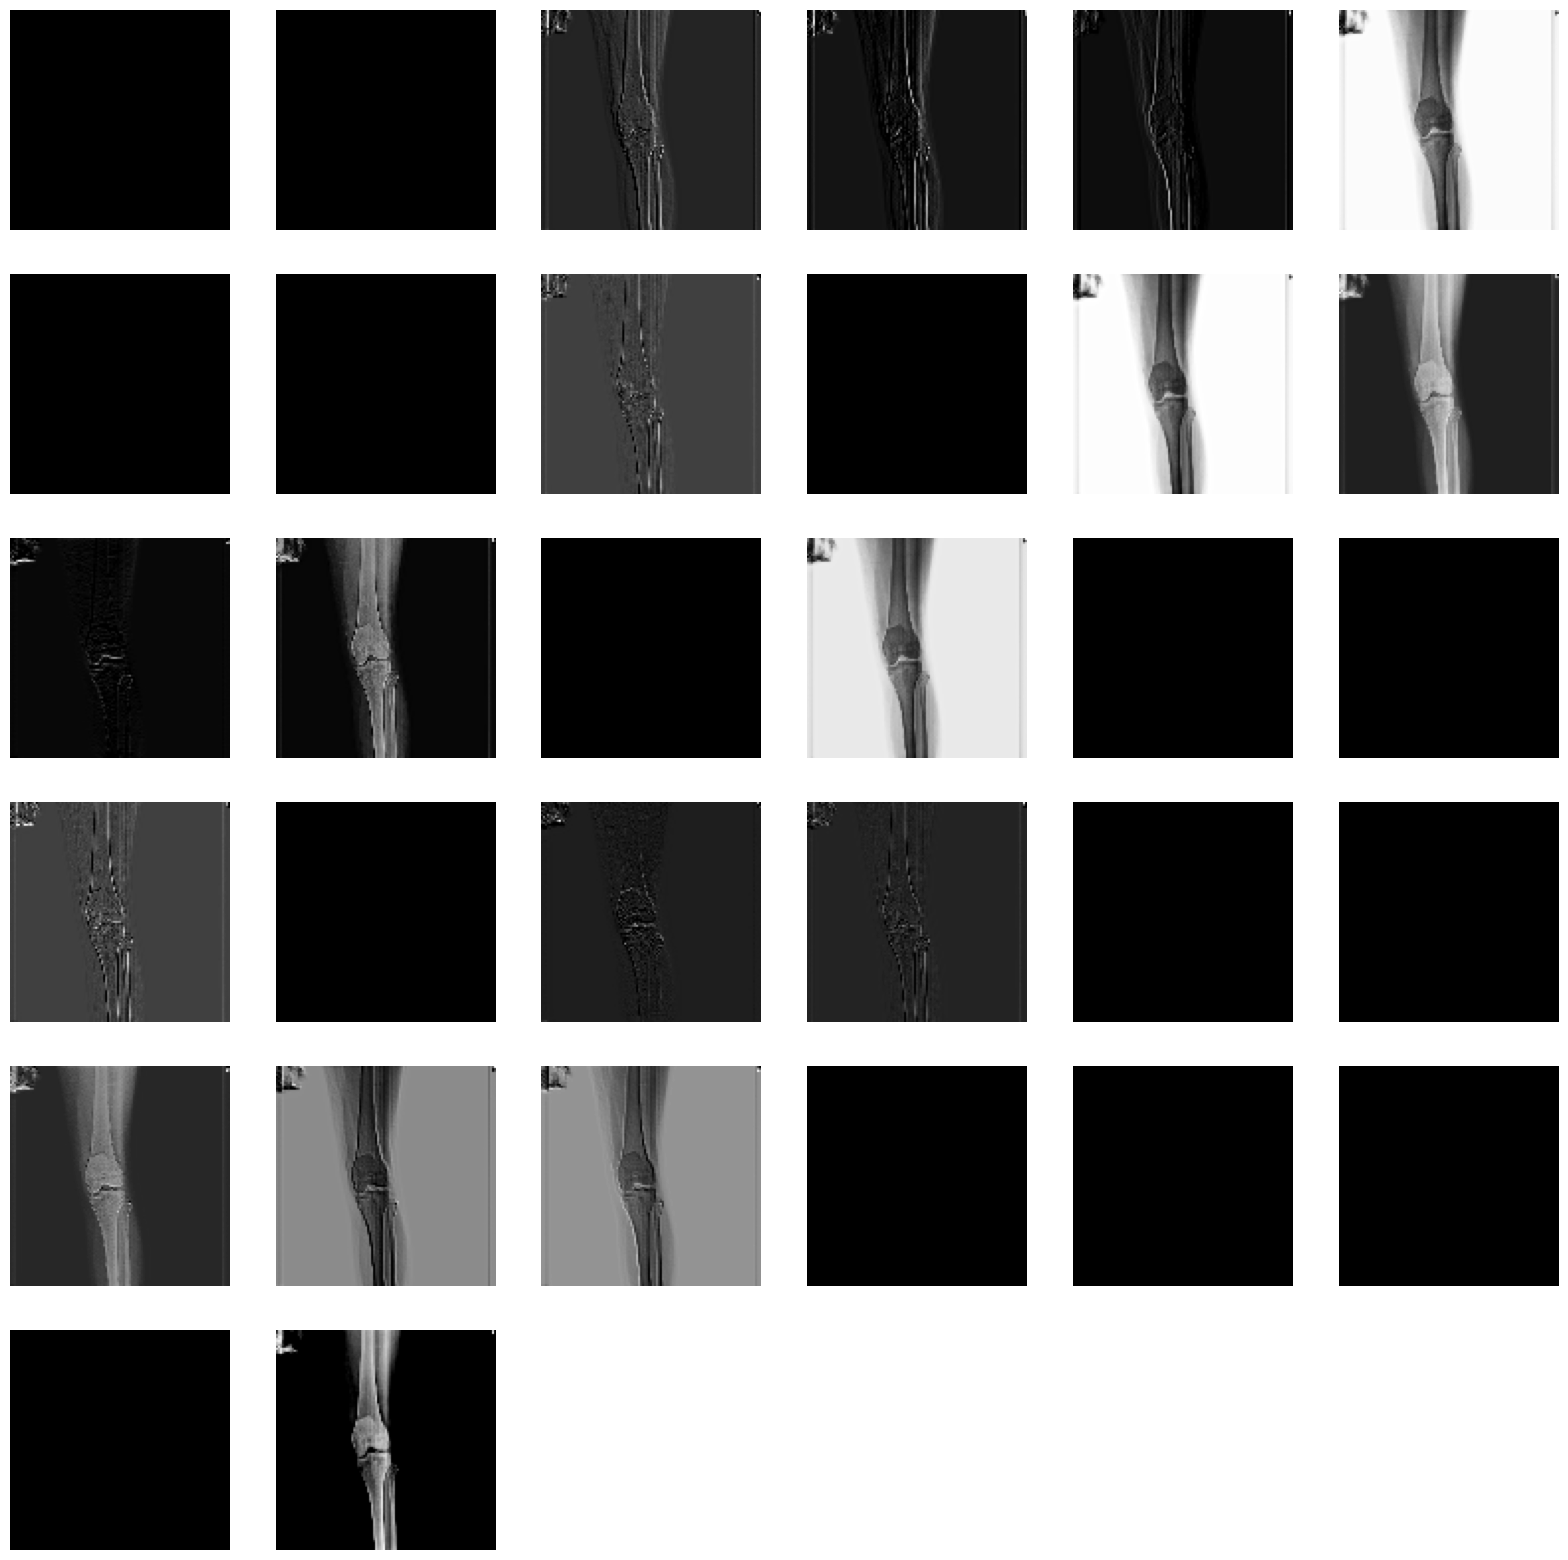

In [35]:
# Show the feature map
layer1 = model.features[0]
input,output = next(iter(train_loader))
print(input.shape)
input = input.to(device)
output = output.to(device)
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(32):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_image[i], cmap='gray')
    plt.axis('off') 


### Visual Transformer

--------------------Epoch 1--------------------
Train_accuracy: 56.65% | Train_loss: 249.0863
--------------------Epoch 2--------------------
Train_accuracy: 55.67% | Train_loss: 203.1399
--------------------Epoch 3--------------------
Train_accuracy: 58.62% | Train_loss: 217.9892
--------------------Epoch 4--------------------
Train_accuracy: 60.59% | Train_loss: 190.0129
--------------------Epoch 5--------------------
Train_accuracy: 59.11% | Train_loss: 194.8338
--------------------Epoch 6--------------------
Train_accuracy: 62.56% | Train_loss: 191.1626
--------------------Epoch 7--------------------
Train_accuracy: 58.13% | Train_loss: 190.7935
--------------------Epoch 8--------------------
Train_accuracy: 63.55% | Train_loss: 187.9302
--------------------Epoch 9--------------------
Train_accuracy: 58.13% | Train_loss: 221.2449
--------------------Epoch 10--------------------
Train_accuracy: 58.62% | Train_loss: 207.9979


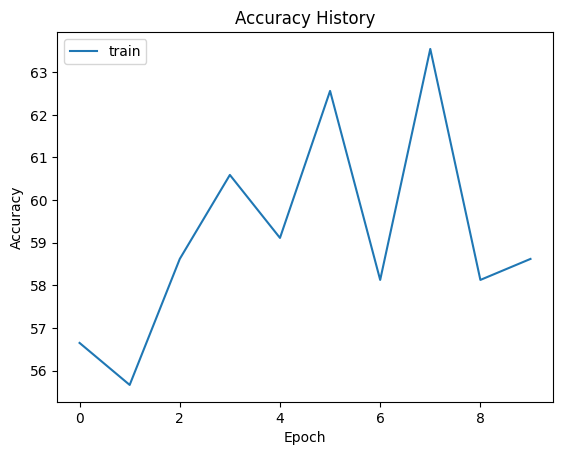

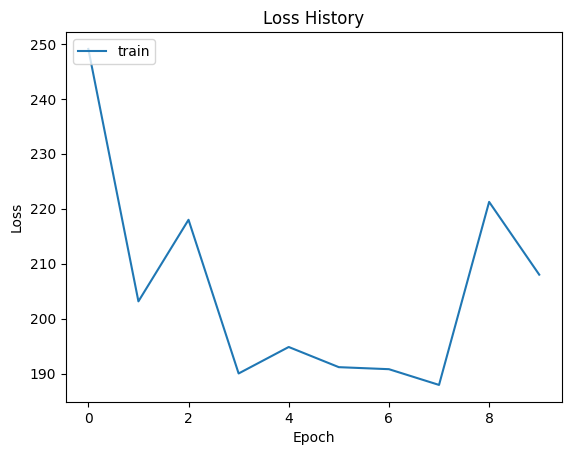

Accuracy on the test images: 63.89%
Inference time: 456.3392 milliseconds


In [8]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3).to(device)
vit_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vit_trainer.train()
vit_trainer.predict()

In [13]:
model.blocks.

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

torch.Size([1, 3, 224, 224])
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([1, 768, 14, 14])
(768, 14, 14)


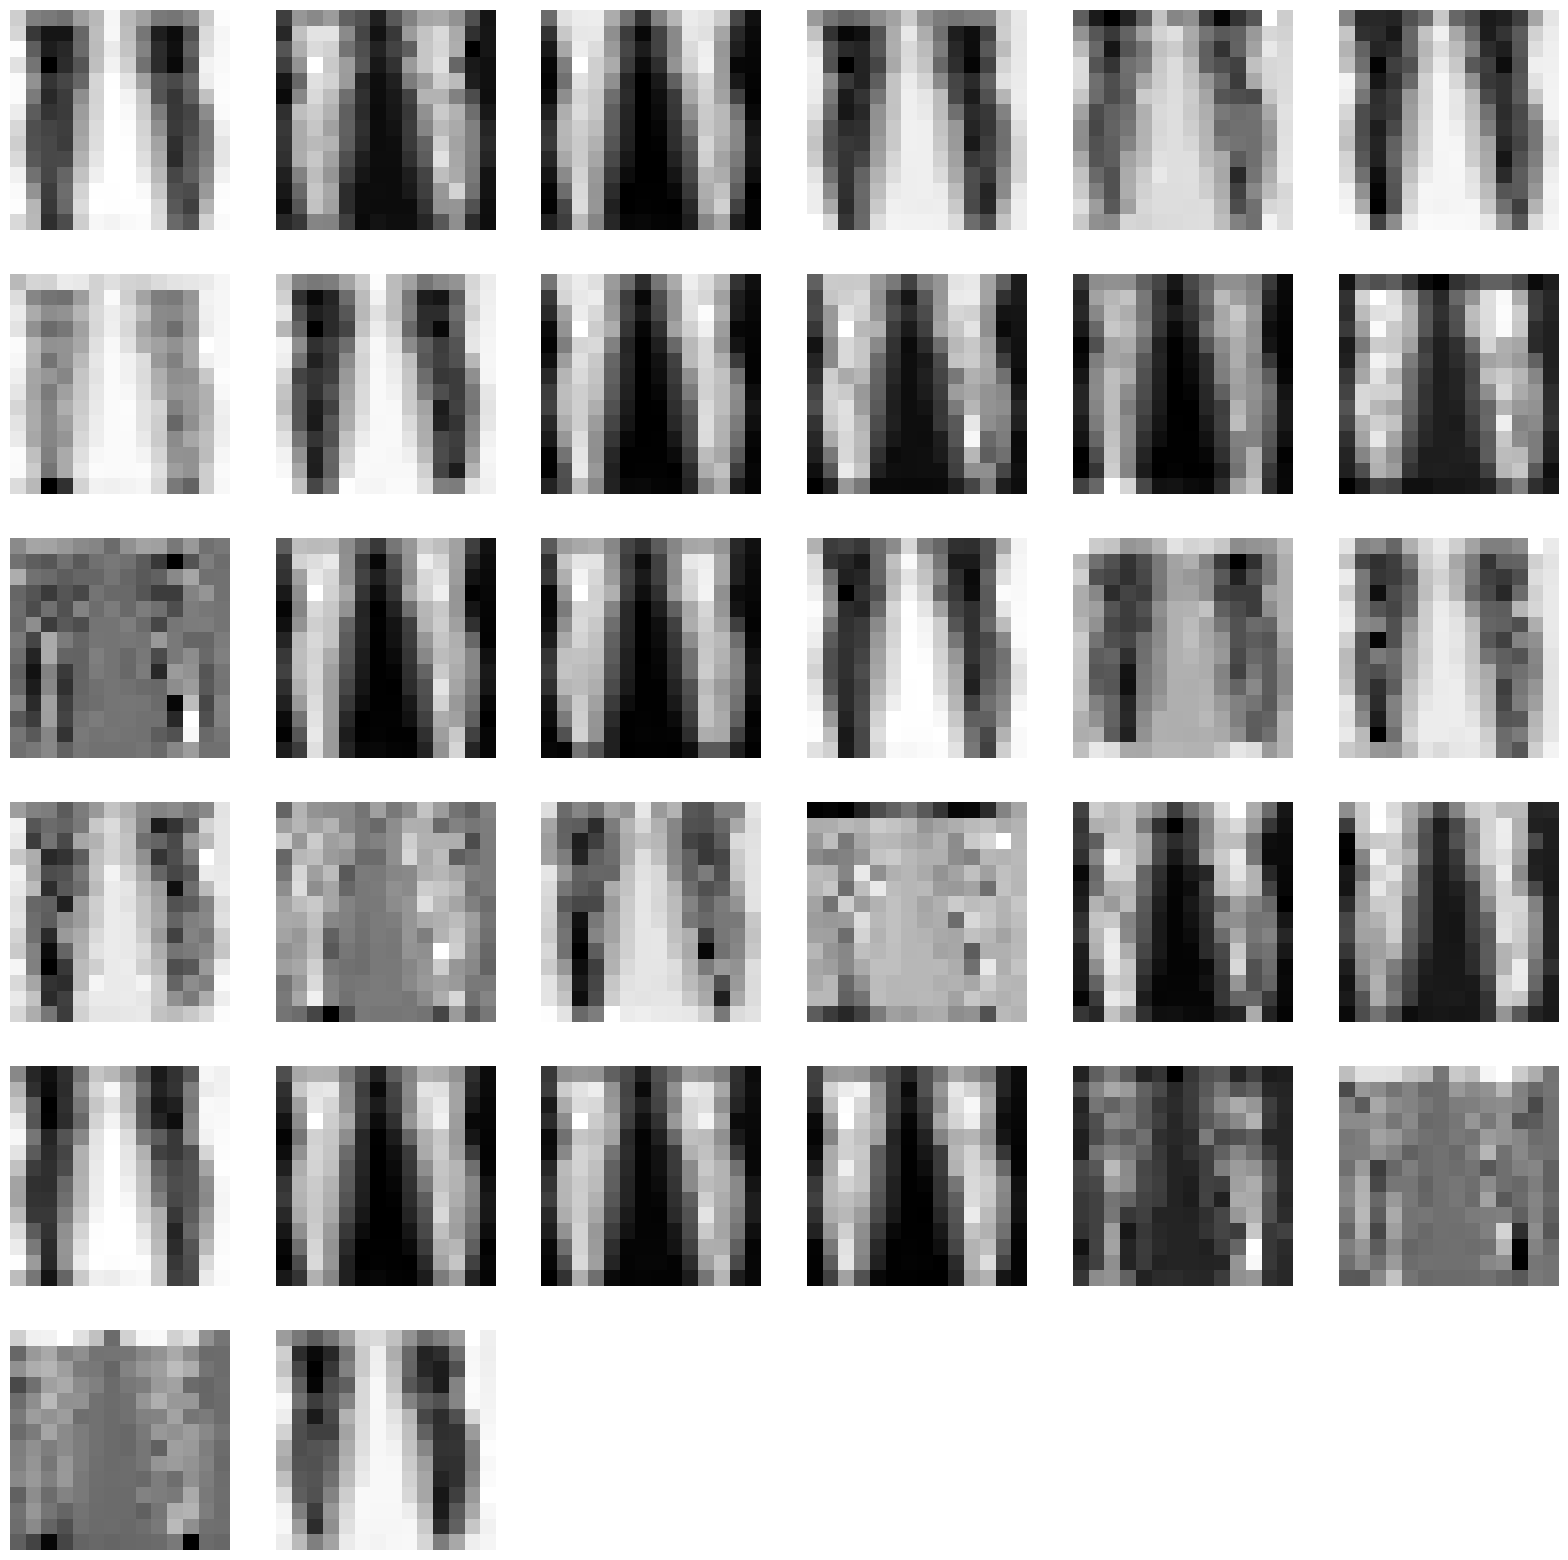

In [15]:

# Show the feature map
layer1 = model.patch_embed.proj
input,output = next(iter(train_loader))
print(input.shape)
input = input.to(device)
output = output.to(device)
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(32):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_image[i], cmap='gray')
    plt.axis('off') 

### Swin-Transformer
- https://github.com/microsoft/Swin-Transformer

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


--------------------Epoch 1--------------------
Train_accuracy: 63.05% | Train_loss: 191.4681
--------------------Epoch 2--------------------
Train_accuracy: 61.58% | Train_loss: 182.4587
--------------------Epoch 3--------------------
Train_accuracy: 64.04% | Train_loss: 188.5485
--------------------Epoch 4--------------------
Train_accuracy: 64.04% | Train_loss: 188.3301
--------------------Epoch 5--------------------
Train_accuracy: 65.02% | Train_loss: 186.0477
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 186.1509
--------------------Epoch 7--------------------
Train_accuracy: 64.04% | Train_loss: 183.5536
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 185.5447
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 185.4314
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 184.5802


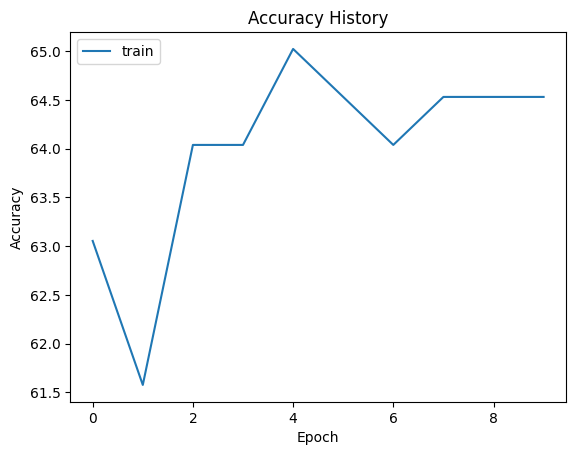

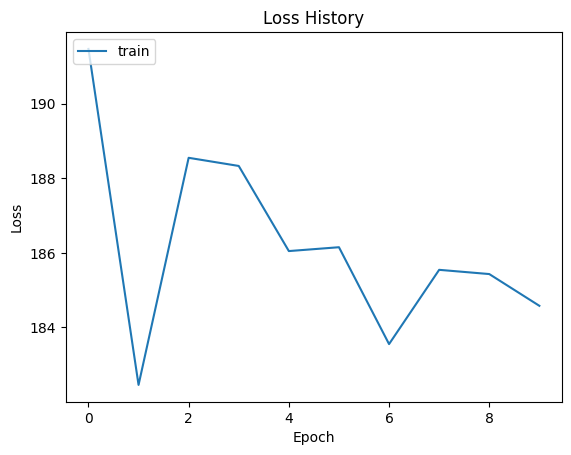

Accuracy on the test images: 63.89%
Inference time: 531.7076 milliseconds


In [8]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=3).to(device)
swin_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-5)
swin_trainer.train()
swin_trainer.predict()

In [9]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (d

torch.Size([1, 3, 224, 224])
Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
torch.Size([1, 128, 56, 56])
(128, 56, 56)


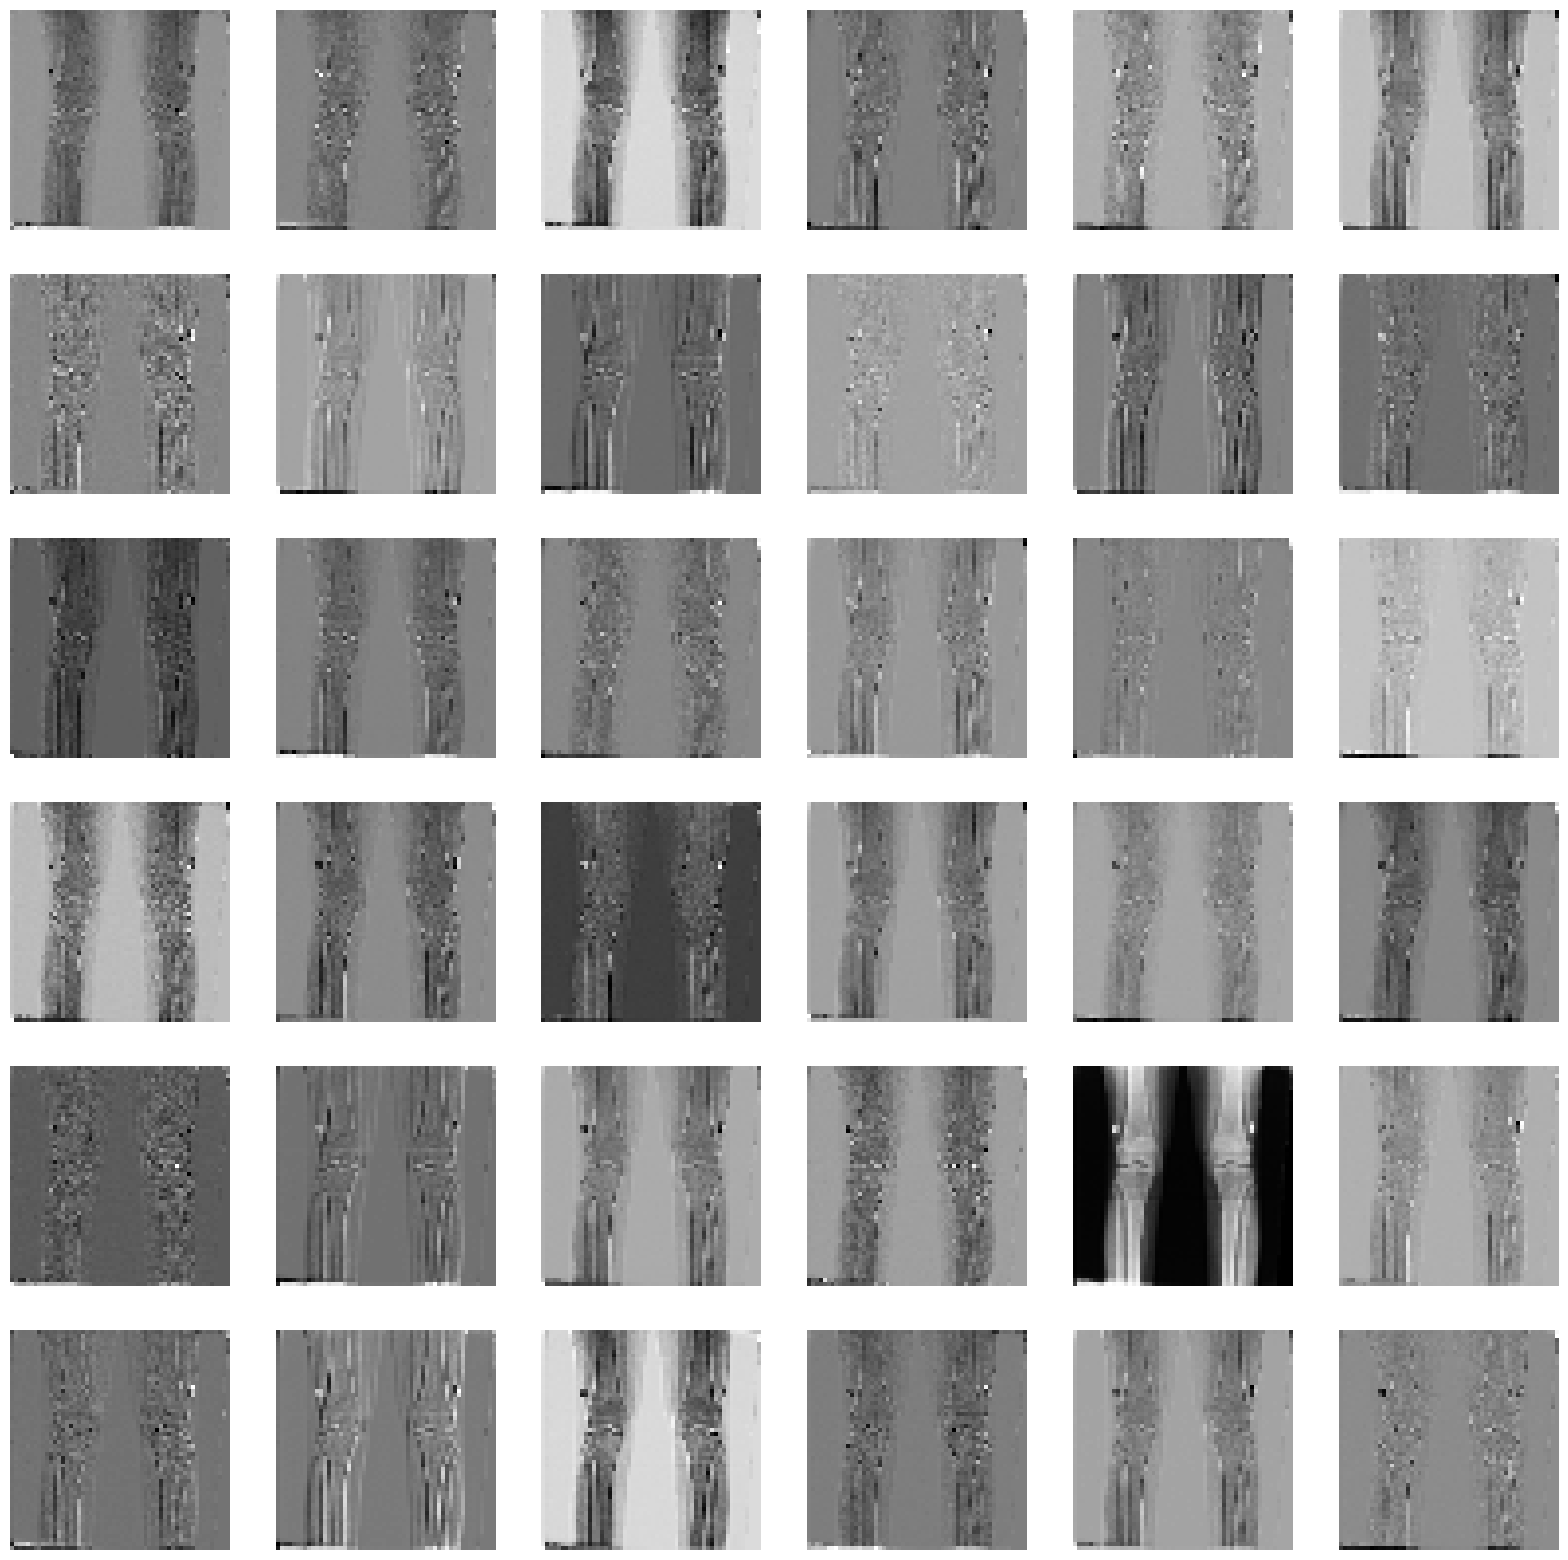

In [11]:
# Show the feature map
layer1 = model.patch_embed.proj
input,output = next(iter(train_loader))
print(input.shape)
input = input.to(device)
output = output.to(device)
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_image[i], cmap='gray')
    plt.axis('off') 